In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/supp_figure_stable_recording'
# figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp'
misc.get_or_create_subdir(figdir)
# misc.get_or_create_subdir(figdir_supp)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [3]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [4]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'
matplotlib.rcParams['font.size']=10

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']
fr_map_trial_df_pyr_combined_all = prepped_data_agg['fr_map_trial_df_pyr_combined_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']
pf_params_all = prepped_data_agg['pf_params_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [6]:
ii=1
data_dir_full = subdb.iloc[ii]['data_dir_full']
ani=subdb.iloc[ii]['animal_name.1']
sess=subdb.iloc[ii]['sess_name']

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
# beh_df = prep_res['beh_df'].as_dataframe()
# beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

ripples = mat_to_return['ripples']
ripple_events = ripples

cell_metrics=mat_to_return.cell_metrics
mergepoints = mat_to_return.mergepoints

cell_type_mask=mat_to_return['cell_type_mask']

load *SessionPulses.Events.mat failed


In [11]:
all_sw_with_metrics_d_all.loc[ani,sess,0].columns

/tmp/ipykernel_969966/3374768928.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics_d_all.loc[ani,sess,0].columns


Index(['trialtype', 'uid', 'field_index', 'time', 'speed_gauss', 'field_pos',
       'trial_index', 'switch', 'index_within', 'switch_trial',
       'switch_trial_frac', 'pre_ntrials_in_segment',
       'post_ntrials_in_segment', 'pre_mean_fr_1', 'pre_mean_fr_2',
       'pre_mean_fr_3', 'pre_mean_fr_all', 'post_mean_fr_1', 'post_mean_fr_2',
       'post_mean_fr_3', 'post_mean_fr_all', 'pre_mean_fr_1_norm',
       'pre_mean_fr_2_norm', 'pre_mean_fr_3_norm', 'pre_mean_fr_all_norm',
       'post_mean_fr_1_norm', 'post_mean_fr_2_norm', 'post_mean_fr_3_norm',
       'post_mean_fr_all_norm', 'pre_ntrial_le_10_perc',
       'pre_ntrial_le_30_perc', 'pre_ntrial_le_50_perc',
       'pre_ntrial_le_70_perc', 'pre_ntrial_le_90_perc',
       'pre_ntrial_ge_10_perc', 'pre_ntrial_ge_30_perc',
       'pre_ntrial_ge_50_perc', 'pre_ntrial_ge_70_perc',
       'pre_ntrial_ge_90_perc', 'post_ntrial_le_10_perc',
       'post_ntrial_le_30_perc', 'post_ntrial_le_50_perc',
       'post_ntrial_le_70_perc', 'pos

In [111]:
ti=0
subdb=all_sw_with_metrics_d_all.loc[ani,sess,ti].query('switch==1&pre_mean_fr_all_norm<0.3')
row=subdb.sample(1).iloc[0]
uid=row['uid']
field_id = row['field_index']
tt=row['trialtype']


/tmp/ipykernel_969966/441440037.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  subdb=all_sw_with_metrics_d_all.loc[ani,sess,ti].query('switch==1&pre_mean_fr_all_norm<0.3')


In [110]:
# row_l = []
row_l.append(row)

In [112]:
uid

272

/tmp/ipykernel_969966/1940856256.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  rm=fr_map_trial_df_pyr_combined_all.loc[ani,sess,ti,tt,uid].dropna(axis=1).T
/mnt/home/szheng/projects/util_code/plot_helper.py:578: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


(<Figure size 216x144 with 2 Axes>, <Axes: xlabel='Position'>)

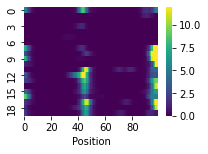

In [113]:
rm=fr_map_trial_df_pyr_combined_all.loc[ani,sess,ti,tt,uid].dropna(axis=1).T
ph.ratemap_one_raw(rm)

In [35]:
import pynapple as nap

ripple_times=nap.IntervalSet(start=ripple_events['timestamps'][:,0],end=ripple_events['timestamps'][:,1])

epoch_time = nap.IntervalSet(start=mergepoints.timestamps[:,0],end=mergepoints.timestamps[:,1])

In [114]:
ripple_events_timestamps = ripple_events['timestamps']
selected_interval = mergepoints.timestamps[1]
spike_times = cell_metrics.spikes.times
spike_times_in_ripple_l,mask_l, ripple_time_ints_l = prep.get_spike_times_in_ripple_l(spike_times,ripple_events_timestamps,selected_interval,ripple_window_extension=None,cell_type_mask=None)





In [58]:
spk_beh_df=spk_beh_df_all.loc[ani,sess]

/tmp/ipykernel_969966/3430176532.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df=spk_beh_df_all.loc[ani,sess]


<Axes: >

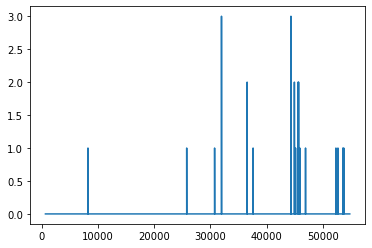

In [115]:
spk_beh_df.query('pause_event')[uid].plot()

In [116]:
trial_index_to_index_within_df=dpp.trial_index_to_index_within_trialtype(spk_beh_df)

In [117]:
trial_index_to_index_within_df.loc[ti,tt]

trial_ind
0.0      0
2.0      1
4.0      2
6.0      3
11.0     4
12.0     5
13.0     6
15.0     7
17.0     8
18.0     9
20.0    10
21.0    11
23.0    12
24.0    13
26.0    14
27.0    15
28.0    16
29.0    17
30.0    18
31.0    19
Name: index, dtype: int64

/mnt/home/szheng/projects/util_code/plot_helper.py:578: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


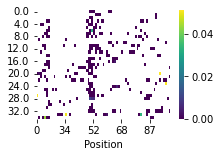

In [118]:
rm=spk_beh_df.query('pause_event').groupby(['trial','lin_binned']).mean()[uid].unstack()
fig,ax=ph.ratemap_one_raw(rm)
# ax.set_xticks(np.arange(0,100,20))


/mnt/home/szheng/projects/util_code/plot_helper.py:578: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


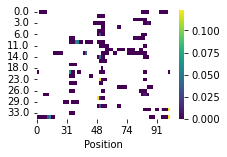

In [127]:
rm=spk_beh_df.query('off_track_event').groupby(['trial','lin_binned']).mean()[uid].unstack()
fig,ax=ph.ratemap_one_raw(rm)
# ax.set_xticks(np.arange(0,100,20))


In [130]:
spike_trains.restrict()

  Index    rate  celltype              ispyr    isint
-------  ------  ------------------  -------  -------
      1   19.78  Narrow Interneuron        0        1
      2   17.69  Narrow Interneuron        0        1
      3   17.99  Narrow Interneuron        0        1
      4   20.36  Narrow Interneuron        0        1
      5   19.06  Narrow Interneuron        0        1
      6   21.01  Narrow Interneuron        0        1
      7   21.29  Narrow Interneuron        0        1
      8   16.28  Narrow Interneuron        0        1
      9   16.42  Narrow Interneuron        0        1
     10   15.26  Narrow Interneuron        0        1
     11   16.04  Narrow Interneuron        0        1
     12   14.28  Narrow Interneuron        0        1
     13   15.79  Narrow Interneuron        0        1
     14   17.91  Narrow Interneuron        0        1
     15   19.26  Narrow Interneuron        0        1
     16   14.72  Narrow Interneuron        0        1
     17   11.37  Narrow Inte

In [132]:
spike_times_in_ripple_l[uid][3]

array([7471.09123333, 7471.0981    ])

In [138]:
spks

array([7471.0941    , 7471.10436667, 7471.1075    ])

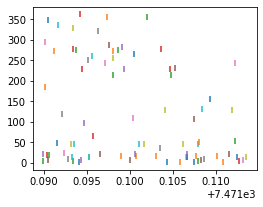

In [158]:
fig,ax=plt.subplots(figsize=(4,3))
rip_id=3
for ii,uu in enumerate(spike_times_in_ripple_l):
    spks = uu[rip_id]
    if len(spks) > 0:

        ax.scatter(spks,[ii+1]*len(spks),marker='|')



In [144]:
fr_map_onesess=fr_map_all.loc[ani,sess,ti,tt]

/tmp/ipykernel_969966/1427506368.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_onesess=fr_map_all.loc[ani,sess,ti,tt]


In [154]:
win = nap.IntervalSet(start=0.09+7.471e3,end=0.120+7.471e3)

In [264]:
rip_st_beh = rip_st.restrict(epoch_time.iloc[[1]])
ii=3
win = nap.IntervalSet(start=rip_st_beh.index[ii],end=rip_st_beh.index[ii]+0.05)

In [265]:
spk_binned_within_rip=spike_trains.restrict(win).count(0.01)

spk_binned_within_rip_pyr = spk_binned_within_rip[cell_cols_d['pyr']]

spk_binned_within_rip_pyr= pd.DataFrame(spk_binned_within_rip_pyr).reset_index(drop=True).T

t_cols=[f't{i}' for i in spk_binned_within_rip_pyr.columns]
spk_binned_within_rip_pyr.columns = t_cols

In [266]:
corr=pd.concat([fr_map_onesess,spk_binned_within_rip_pyr],axis=1).corr(method='spearman')

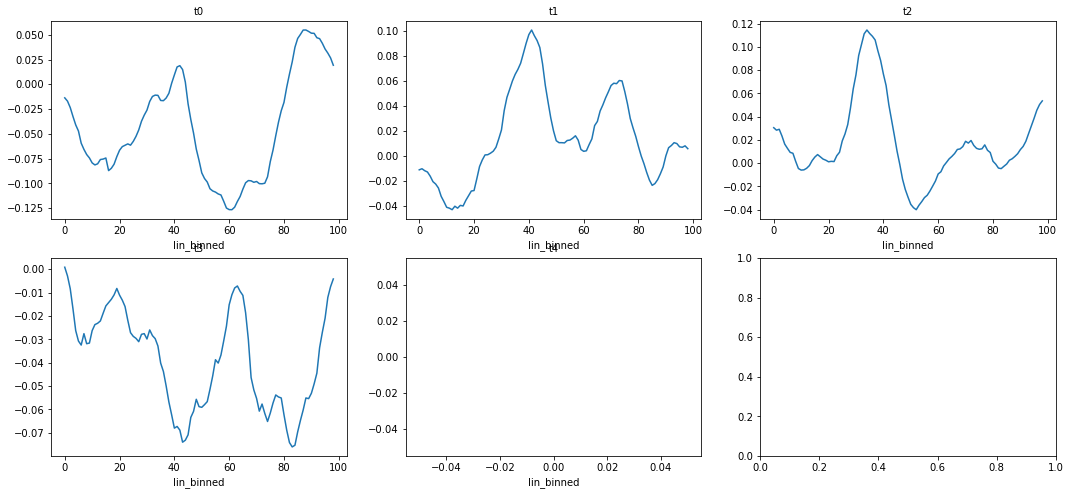

In [267]:
nplots = len(t_cols)
fig,axs=ph.subplots_wrapper(nplots)
for ii,t in enumerate(t_cols):
    ax=axs.ravel()[ii]
    corr[t].loc[fr_map_onesess.columns].plot(ax=ax)
    ax.set_title(t)


In [190]:
fr_map_onesess

lin_binned,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
31.0,3.760543,3.900929,4.205865,4.664637,5.258422,5.966223,6.752117,7.537195,8.144267,8.337348,...,1.355974,1.192720,1.251877,1.515371,1.916745,2.346233,2.682269,2.850424,2.875820,2.851263
32.0,0.326118,0.312275,0.294713,0.288860,0.311570,0.382754,0.526952,0.758822,1.035011,1.219490,...,0.745852,0.477723,0.279695,0.166287,0.121734,0.120206,0.133767,0.146868,0.155410,0.159472
33.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.088179,0.046420,0.022462,0.009908,0.003838,0.001316,0.000294,0.000068,0.000014,0.000000
34.0,1.140574,1.134736,1.130368,1.134354,1.159659,1.222981,1.328657,1.447382,1.505661,1.444680,...,1.274132,1.387000,1.432927,1.403718,1.301289,1.136743,0.932270,0.729333,0.572691,0.489280
35.0,0.352049,0.413034,0.519736,0.688639,0.987991,1.536472,2.502700,4.115682,6.575298,9.830705,...,0.160617,0.112384,0.097400,0.116606,0.163967,0.229568,0.298663,0.355623,0.391739,0.407775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000189,0.000830,0.003022,0.008885,0.020524,0.036911,0.053028,0.064534,0.070878,0.073481
373.0,0.003742,0.007579,0.017099,0.037893,0.081925,0.168036,0.319792,0.560967,0.894017,1.256470,...,0.027073,0.046515,0.067806,0.085657,0.094790,0.091745,0.076802,0.055122,0.034807,0.022885
374.0,0.786845,1.227566,2.089289,3.408809,5.227817,7.476030,9.924167,12.225100,13.910023,14.461932,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
375.0,1.035685,0.890980,0.689970,0.499124,0.345898,0.235945,0.160550,0.103841,0.056912,0.024077,...,0.543105,0.615445,0.655231,0.656226,0.627374,0.586850,0.545206,0.496929,0.443620,0.406524


In [176]:
fr_map_onesess

lin_binned,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
31.0,3.760543,3.900929,4.205865,4.664637,5.258422,5.966223,6.752117,7.537195,8.144267,8.337348,...,1.355974,1.192720,1.251877,1.515371,1.916745,2.346233,2.682269,2.850424,2.875820,2.851263
32.0,0.326118,0.312275,0.294713,0.288860,0.311570,0.382754,0.526952,0.758822,1.035011,1.219490,...,0.745852,0.477723,0.279695,0.166287,0.121734,0.120206,0.133767,0.146868,0.155410,0.159472
33.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.088179,0.046420,0.022462,0.009908,0.003838,0.001316,0.000294,0.000068,0.000014,0.000000
34.0,1.140574,1.134736,1.130368,1.134354,1.159659,1.222981,1.328657,1.447382,1.505661,1.444680,...,1.274132,1.387000,1.432927,1.403718,1.301289,1.136743,0.932270,0.729333,0.572691,0.489280
35.0,0.352049,0.413034,0.519736,0.688639,0.987991,1.536472,2.502700,4.115682,6.575298,9.830705,...,0.160617,0.112384,0.097400,0.116606,0.163967,0.229568,0.298663,0.355623,0.391739,0.407775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000189,0.000830,0.003022,0.008885,0.020524,0.036911,0.053028,0.064534,0.070878,0.073481
373.0,0.003742,0.007579,0.017099,0.037893,0.081925,0.168036,0.319792,0.560967,0.894017,1.256470,...,0.027073,0.046515,0.067806,0.085657,0.094790,0.091745,0.076802,0.055122,0.034807,0.022885
374.0,0.786845,1.227566,2.089289,3.408809,5.227817,7.476030,9.924167,12.225100,13.910023,14.461932,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
375.0,1.035685,0.890980,0.689970,0.499124,0.345898,0.235945,0.160550,0.103841,0.056912,0.024077,...,0.543105,0.615445,0.655231,0.656226,0.627374,0.586850,0.545206,0.496929,0.443620,0.406524


In [174]:
pd.DataFrame(spk_binned_within_rip_pyr).T

Time (s),7471.0925,7471.0975,7471.1025,7471.1075,7471.1125,7471.1175
31,0,0,0,0,0,0
32,0,0,0,0,0,0
33,0,0,0,0,0,0
34,0,0,0,0,0,0
35,0,0,0,0,0,0
...,...,...,...,...,...,...
372,0,0,0,0,0,0
373,0,0,0,0,0,0
374,0,0,0,0,0,0
375,0,0,0,0,0,0


  Index    rate  celltype              ispyr    isint
-------  ------  ------------------  -------  -------
      1   19.78  Narrow Interneuron        0        1
      2   17.69  Narrow Interneuron        0        1
      3   17.99  Narrow Interneuron        0        1
      4   20.36  Narrow Interneuron        0        1
      5   19.06  Narrow Interneuron        0        1
      6   21.01  Narrow Interneuron        0        1
      7   21.29  Narrow Interneuron        0        1
      8   16.28  Narrow Interneuron        0        1
      9   16.42  Narrow Interneuron        0        1
     10   15.26  Narrow Interneuron        0        1
     11   16.04  Narrow Interneuron        0        1
     12   14.28  Narrow Interneuron        0        1
     13   15.79  Narrow Interneuron        0        1
     14   17.91  Narrow Interneuron        0        1
     15   19.26  Narrow Interneuron        0        1
     16   14.72  Narrow Interneuron        0        1
     17   11.37  Narrow Inte

In [141]:
uid

272

In [119]:
rip_st=nap.Ts(ripple_times['start'].values)

In [120]:
epoch_time

,start,end
0,0.000,6572.415967
1,6572.416,8443.455967
2,8443.456,14062.655967
3,14062.656,16455.167967
4,16455.168,25502.399967


In [121]:
rip_st.restrict(epoch_time.iloc[[1]])

Time (s)
7209.1080   NaN
7400.0904   NaN
7443.6560   NaN
7471.0896   NaN
7568.3056   NaN
7568.6912   NaN
7570.5752   NaN
7787.8256   NaN
7846.5448   NaN
7851.1616   NaN
7885.0000   NaN
7886.2352   NaN
7936.6312   NaN
7942.9096   NaN
8089.7632   NaN
8095.0632   NaN
8105.4272   NaN
8130.2600   NaN
8139.6400   NaN
8285.6336   NaN
8352.1672   NaN
8360.3904   NaN
8364.4152   NaN
8371.1424   NaN
8425.0216   NaN
dtype: float64

In [103]:
idx=(spk_beh_df['time']-7209).abs().idxmin()

In [106]:
spk_beh_df.loc[idx]['pause_event']

True

array([array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([7471.09123333, 7471.0981    ]),
       array([7568.33746667]), array([7568.69366667]),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([7886.2559]),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64)], dtype=object)

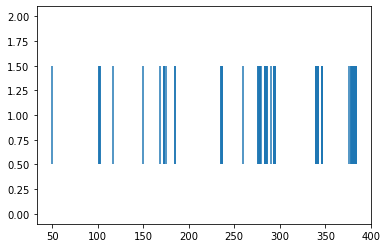

In [32]:
plt.eventplot(spike_trains[uid].index[:100])

In [30]:
spike_trains[uid]

Time (s)
49.620233      NaN
101.828133     NaN
101.955733     NaN
102.371767     NaN
102.762033     NaN
                ..
25494.597033   NaN
25497.107333   NaN
25500.453900   NaN
25501.364967   NaN
25501.378333   NaN
Length: 6522, dtype: float64

In [7]:
spike_trains

  Index    rate  celltype              ispyr    isint
-------  ------  ------------------  -------  -------
      1   19.78  Narrow Interneuron        0        1
      2   17.69  Narrow Interneuron        0        1
      3   17.99  Narrow Interneuron        0        1
      4   20.36  Narrow Interneuron        0        1
      5   19.06  Narrow Interneuron        0        1
      6   21.01  Narrow Interneuron        0        1
      7   21.29  Narrow Interneuron        0        1
      8   16.28  Narrow Interneuron        0        1
      9   16.42  Narrow Interneuron        0        1
     10   15.26  Narrow Interneuron        0        1
     11   16.04  Narrow Interneuron        0        1
     12   14.28  Narrow Interneuron        0        1
     13   15.79  Narrow Interneuron        0        1
     14   17.91  Narrow Interneuron        0        1
     15   19.26  Narrow Interneuron        0        1
     16   14.72  Narrow Interneuron        0        1
     17   11.37  Narrow Inte